# **Midterm Project**

## Name: CANOY RAYMART JAY
## Student ID #: 2020021376



## **(00) Setting up**

In [ ]:
# Python >= 3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn >= 0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Making this notebook's output stable across runs
np.random.seed(42)

# Location for saving the midterm project
PROJECT_ROOT_DIR = '.'
PROJECT_ID = 'midterm'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', PROJECT_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# Saving Figure
def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
  path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
  print("Saving figure", fid_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

#### **Functions that will be used in the analysis**

In [ ]:
from scipy import stats
from scipy.stats import shapiro
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from joblib import dump, load
from sklearn.model_selection import GridSearchCV

# Normality Test
def normality_test(data):
  shapiro_test = shapiro(data);
  if shapiro_test[1] >= 0.05:
    print('Using Shapiro-Wilky Test, the p-value is {}. Therefore, the data was drawn from a normal distribution.'.format(round(shapiro_test[1], 5)))
  else:
    print('Using Shapiro-Wilky Test, the p-value is {}. Therefore, the data MAY NOT be drawn from a normal distribution'.format(round(shapiro_test[1], 5)))
    print('-'*130)
    print('Testing for lognormality . . .')
    logNorm_shapiro_test = shapiro(np.log(data))
    if logNorm_shapiro_test[1] >= 0.05:
      print('Using Shapiro-Wilky Test, the p-value is {}. Therefore, the log(data) was drawn from a normal distribution.'.format(round(logNorm_shapiro_test[1], 5)))
    else:
      print('Using Shapiro-Wilky Test, the p-value is {}. Therefore, the log(data) MAY NOT be drawn from a normal distribution'.format(round(logNorm_shapiro_test[1], 5)))
      print('Try performing an outlier test.')



def plot_learning_curves_MAE(model, X, y, figsize_, title_):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
  train_errors, val_errors = [], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_absolute_error(y_train[:m], y_train_predict))
    val_errors.append(mean_absolute_error(y_val, y_val_predict))
  plt.figure(figsize=figsize_)
  plt.plot(train_errors, "r-+", linewidth=2, label="train")
  plt.plot(val_errors, "b-", linewidth=3, label="val")
  plt.legend(loc="upper right", fontsize=16)
  plt.xlabel('Training set size', fontsize=16)
  plt.ylabel('MAE', fontsize=16)
  plt.title('Learning Curve [MAE] ({})'.format(title_), fontsize=18)

def plot_learning_curves_RMSE(model, X, y, figsize_, title_):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
  train_errors, val_errors = [], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
  plt.figure(figsize=figsize_)
  plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
  plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
  plt.legend(loc="upper right", fontsize=16)
  plt.xlabel('Training set size', fontsize=16)
  plt.ylabel('MAE', fontsize=16)
  plt.title('Learning Curve [RMSE] ({})'.format(title_), fontsize=18)

## **(01) Getting and taking a quick look at the data**

### **Downloading and reading the data**

In [ ]:
FILE_ROOT = 'https://raw.githubusercontent.com/rjcanoy03/BRI507/'
FILE_PATH = os.path.join(FILE_ROOT, 'Midterm_Project')
FILE_NAME = 'train_data.csv'

def get_data(file_path=FILE_PATH, filename=FILE_NAME):
  csv_path = os.path.join(file_path, filename)
  print("Downloading and reading", filename)
  return pd.read_csv(csv_path)

* Taking a peek at the top 10 rows of the training dataset

In [ ]:
alzheimers_data = get_data()
alzheimers_data.head(10)

,DX_bl,ADAS11,ADAS13,MMSE,ST102CV,ST103CV,ST104CV,ST105CV,ST106CV,ST107CV,ST108CV,ST109CV,ST110CV,ST111CV,ST113CV,ST114CV,ST115CV,ST116CV,ST117CV,ST118CV,ST119CV,ST121CV,ST123CV,ST129CV,ST130CV,ST13CV,ST14CV,ST15CV,ST23CV,ST24CV,ST25CV,ST26CV,ST31CV,ST32CV,ST34CV,ST35CV,ST36CV,ST38CV,ST39CV,ST40CV,...,ST34TA,ST35TA,ST36TA,ST38TA,ST39TA,ST40TA,ST43TA,ST44TA,ST45TA,ST46TA,ST47TA,ST48TA,ST49TA,ST50TA,ST51TA,ST52TA,ST54TA,ST55TA,ST56TA,ST57TA,ST58TA,ST59TA,ST60TA,ST62TA,ST64TA,ST72TA,ST73TA,ST74TA,ST82TA,ST83TA,ST84TA,ST85TA,ST90TA,ST91TA,ST93TA,ST94TA,ST95TA,ST97TA,ST98TA,ST99TA
0,0,9.00,14.00,27,3295,1760,2957,1975,3270,1871,9504,3219,12683,8167,1956,15106,18296,12517,11914,9771,2024,1221,6627.0,6245,5844,2361,2161,4782,2116,1757.0,723,6714,11308,10841,1669,8168,6690,6040,3858,11530,...,2.098,1.965,2.666,1.690,2.328,2.636,2.159,2.354,2.174,2.331,2.335,1.353,1.757,2.270,2.189,2.099,2.695,2.112,2.537,2.004,2.698,2.445,3.461,2.216,1.004,2.480,2.428,2.234,1.670,3.132,2.467,2.424,2.345,2.914,2.461,2.129,2.519,1.606,2.363,2.864
1,0,5.00,7.00,26,3644,1926,4376,2723,4806,1756,10159,2972,13170,10227,1754,14615,18758,12629,9276,10399,2057,842,NaN,7175,5860,2154,2159,5930,2979,1770.0,761,10683,10900,11519,2544,10561,7039,6141,4148,9033,...,2.719,2.031,2.429,2.204,2.079,2.852,2.367,2.887,2.543,2.395,2.431,1.712,2.034,2.602,2.598,2.246,2.401,2.142,2.574,2.169,2.877,2.602,3.375,2.382,NaN,2.657,2.543,2.348,1.948,3.782,2.440,2.843,2.499,2.695,2.457,2.254,2.269,1.868,2.142,2.679
2,2,16.33,29.33,25,3096,2191,3784,2344,2675,2063,8561,3208,14310,7538,1571,14405,20381,11549,9488,8848,2175,1109,6150.0,6085,5977,1828,1392,5996,3021,1562.0,489,8597,6703,8310,2281,11219,7499,7580,4451,7417,...,2.253,1.891,2.540,1.879,2.279,2.548,2.298,2.861,2.528,2.827,2.234,1.404,1.940,2.285,2.436,1.800,2.940,2.152,2.692,1.756,2.607,2.221,3.703,2.175,1.064,2.058,2.168,2.414,1.885,3.303,2.702,2.617,2.108,2.526,2.151,2.003,2.534,1.996,2.163,2.643
3,1,6.00,9.00,29,3857,2660,3382,2751,3783,2202,9074,2504,11995,10484,1986,13690,20896,15095,10463,11313,2787,935,NaN,7009,7279,1719,2238,5620,2816,1934.0,925,11194,11349,10076,2299,11054,7071,6329,5498,8785,...,2.643,2.158,2.489,1.952,2.289,2.767,2.199,3.184,2.388,2.671,2.179,1.536,2.137,2.539,2.481,2.376,2.736,2.163,2.638,2.185,2.709,2.328,3.924,2.529,NaN,2.663,2.990,2.469,1.922,4.232,2.546,2.937,2.514,2.875,2.837,2.379,2.315,1.954,2.326,2.989
4,0,5.00,8.00,28,3411,1578,2664,2433,3448,1550,7128,2500,9801,7732,1451,13050,17785,10460,8407,8573,1952,874,NaN,5275,6034,2070,1405,3591,2244,1110.0,652,9601,9964,8338,2059,8735,5546,5859,4480,8762,...,2.644,2.128,2.702,2.065,2.597,2.874,2.281,2.128,2.689,2.955,2.370,1.536,1.990,2.545,2.519,2.286,2.839,2.495,2.812,2.104,2.652,2.549,3.105,2.390,NaN,2.483,2.381,2.498,1.981,3.331,2.954,2.825,2.440,2.848,2.447,2.256,2.497,2.052,2.498,2.829
5,0,3.33,5.33,30,3540,1428,3918,2111,3539,1935,6955,3082,10875,8773,1814,15407,20977,11587,10094,9856,1799,836,7960.0,6815,6610,2549,1745,4919,2491,2458.0,682,7869,11311,11582,1899,10270,6044,5178,4267,11255,...,2.056,1.843,2.503,1.696,2.468,2.598,2.156,2.060,2.341,2.497,2.118,1.551,1.653,2.310,2.052,2.068,2.820,2.080,2.431,1.816,2.443,2.084,3.491,1.776,0.999,2.357,2.339,2.195,1.504,3.472,2.927,2.255,2.359,2.828,1.972,1.868,2.326,1.608,2.173,2.861
6,0,3.00,5.00,30,3428,2254,3809,2713,3551,2899,8591,3085,12310,9920,2258,14615,21006,14769,12775,10551,2657,1108,NaN,6977,7956,3550,1909,5770,2996,2026.0,858,9925,12602,11746,2372,13707,7220,6512,5148,10318,...,2.569,2.421,2.641,2.008,2.693,3.077,2.355,2.943,2.765,2.909,2.876,1.614,2.010,2.643,2.518,2.541,3.058,2.617,3.088,2.276,3.010,2.592,3.789,2.678,NaN,2.729,3.027,2.411,2.003,4.282,2.541,3.029,2.619,3.102,2.773,2.485,2.656,2.214,2.392,3.142
7,1,5.00,11.00,27,3960,1412,3344,1360,2559,1753,7071,2739,8755,6926,1539,11174,14527,12024,8034,6700,1587,513,5516.0,4430,4686,2075,1725,5026,1807,1953.0,360,6680,10128,7727,1703,9640,4919,5768,2611,8757,...,1.918,2.026,2.437,1.794,2.021,2.732,1.972,1.999,2.300,2.438,2.056

* The attributes have the following meaning:
  * **DX_bl**: The diagnosis group of the subjects
  * **ADAS11**: Alzheimer's Disease Assessment Scale (11-question version) [range: 0-70]
  * **ADAS13**: Alzheimer's Disease Assessment Scale (13-question version) [range: 0-85]
  * **MMSE**: Mini-Mental State Examination [range: 0-30]
  * **ST\*\*\*CV**: Cortical volume of 70 brain regions
  * **ST\*\*\*TA**: Average thickness of 70 brain regions

---

### **Taking a quick look at the data to see how much data is missing**

In [ ]:
ad_info = alzheimers_data.info(verbose=True, null_counts=True)
# verbose: prints the full summary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1607 entries, 0 to 1606
Data columns (total 144 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DX_bl    1607 non-null   int64  
 1   ADAS11   1607 non-null   float64
 2   ADAS13   1607 non-null   float64
 3   MMSE     1607 non-null   int64  
 4   ST102CV  1607 non-null   int64  
 5   ST103CV  1607 non-null   int64  
 6   ST104CV  1607 non-null   int64  
 7   ST105CV  1607 non-null   int64  
 8   ST106CV  1607 non-null   int64  
 9   ST107CV  1607 non-null   int64  
 10  ST108CV  1607 non-null   int64  
 11  ST109CV  1607 non-null   int64  
 12  ST110CV  1607 non-null   int64  
 13  ST111CV  1607 non-null   int64  
 14  ST113CV  1607 non-null   int64  
 15  ST114CV  1607 non-null   int64  
 16  ST115CV  1607 non-null   int64  
 17  ST116CV  1607 non-null   int64  
 18  ST117CV  1607 non-null   int64  
 19  ST118CV  1607 non-null   int64  
 20  ST119CV  1607 non-null   int64  
 21  ST121CV  1607

* These are the columns with null values:

In [ ]:
alzheimers_data_isna_columns = alzheimers_data.columns[alzheimers_data.isna().any()].tolist()

print('\n --Columns with null values-- \n')

column_with_non_null = []
number_non_null_values = []
percent_null_values = []

for i in range(len(alzheimers_data_isna_columns)):
  col = alzheimers_data_isna_columns[i]
  column_with_non_null.append(col)
  number_non_null_values.append(alzheimers_data[col].notnull().sum())
  percent_null_values.append(((len(alzheimers_data[col]) - alzheimers_data[col].notnull().sum())/len(alzheimers_data[col]))*100)
  #print('Column:', i, ', ', 'Non-null values: ', alzheimers_data[i].notnull().sum(), ', ', 'Percent null values:', ((len(alzheimers_data[i]) - alzheimers_data[i].notnull().sum())/len(alzheimers_data[i]))*100)


summary_columns_with_non_null_values = pd.DataFrame({
    'Column': column_with_non_null,
    'Number of non-null values': number_non_null_values,
    'Percent of null values': percent_null_values
})
summary_columns_with_non_null_values


 --Columns with null values-- 



,Column,Number of non-null values,Percent of null values
0,ST123CV,760,52.706907
1,ST24CV,1606,0.062228
2,ST44CV,1606,0.062228
3,ST64CV,760,52.706907
4,ST123TA,760,52.706907
5,ST24TA,1606,0.062228
6,ST44TA,1606,0.062228
7,ST64TA,760,52.706907


* Columns **ST123CV**, **ST64CV**, **ST123TA**, **ST64TA** have approximately 52.71% null values. Interestingly, these columns correspond to the cortical volumes and average thickness of regions **ST123** and **ST64**.

* Columns **ST24CV**, **ST44CV**, **ST24TA**, **ST44TA** have approximately 0.062% null values. Again, these columns correspond to the cortical volumes and average thickness of regions **ST24** and **ST44**.

* **One option is to just drop these columns, but I don't want to do that. So instead, I will try to fill in these missing values with predicted values using linear regression.**

---

### **Taking a quick look at the numerical attributes**

In [ ]:
alzheimers_data.describe()

,DX_bl,ADAS11,ADAS13,MMSE,ST102CV,ST103CV,ST104CV,ST105CV,ST106CV,ST107CV,ST108CV,ST109CV,ST110CV,ST111CV,ST113CV,ST114CV,ST115CV,ST116CV,ST117CV,ST118CV,ST119CV,ST121CV,ST123CV,ST129CV,ST130CV,ST13CV,ST14CV,ST15CV,ST23CV,ST24CV,ST25CV,ST26CV,ST31CV,ST32CV,ST34CV,ST35CV,ST36CV,ST38CV,ST39CV,ST40CV,...,ST34TA,ST35TA,ST36TA,ST38TA,ST39TA,ST40TA,ST43TA,ST44TA,ST45TA,ST46TA,ST47TA,ST48TA,ST49TA,ST50TA,ST51TA,ST52TA,ST54TA,ST55TA,ST56TA,ST57TA,ST58TA,ST59TA,ST60TA,ST62TA,ST64TA,ST72TA,ST73TA,ST74TA,ST82TA,ST83TA,ST84TA,ST85TA,ST90TA,ST91TA,ST93TA,ST94TA,ST95TA,ST97TA,ST98TA,ST99TA
count,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,760.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1606.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,...,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1606.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,760.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.00000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000
mean,0.889857,10.687623,16.838836,27.197884,3415.757312,1889.919104,3449.139390,2242.814561,3415.616055,2011.142502,7846.479776,2936.383945,11364.592408,8286.555694,1850.807716,13241.149347,18303.506534,11272.752334,9654.012446,8795.275669,1973.545737,778.663348,6454.726316,6077.756067,6185.471064,2221.753578,1726.772869,5499.126322,2536.539515,1743.722914,632.463597,8752.144368,10421.447418,9484.886123,2291.787181,10295.434972,6516.395146,5719.485999,4226.335408,9084.429994,...,2.384760,2.019114,2.475054,1.821200,2.290044,2.648584,2.157642,2.540934,2.361113,2.526049,2.230354,1.456342,1.849313,2.417301,2.253390,2.139604,2.832131,2.154694,2.497071,2.007938,2.486484,2.306683,3.450963,2.125401,1.043959,2.361660,2.538278,2.313991,1.735683,3.314019,2.552358,2.552088,2.25390,2.698467,2.335464,2.077695,2.463360,1.850768,2.264312,2.705311
std,0.693999,6.564644,9.519048,2.640931,581.050677,338.251043,674.695186,367.721845,684.312622,404.254377,1269.699606,468.884157,1661.823223,1335.890162,448.358620,2068.689775,2513.344508,1794.353279,1419.068470,1408.779918,398.514299,169.764897,985.436973,849.199658,965.356725,476.215463,420.541071,1060.617430,496.723152,461.554683,155.676189,1487.230213,1921.463519,1752.756276,450.197633,1725.348432,830.238911,1011.246790,882.130700,1597.766218,...,0.237534,0.177947,0.186057,0.151925,0.194545,0.233070,0.218050,0.401720,0.184786,0.250136,0.195438,0.146903,0.174317,0.199327,0.242965,0.202077,0.279173,0.164407,0.183875,0.199050,0.231863,0.204175,0.405734,0.272570,0.136194,0.226703,0.302780,0.207063,0.162672,0.545333,0.284886,0.231266,0.21027,0.231743,0.247948,0.188536,0.182837,0.158143,0.206316,0.227434
min,0.000000,0.000000,0.000000,19.000000,1968.000000,790.000000,1757.000000,1105.000000,1499.000000,726.000000,4422.000000,1530.000000,6287.000000,4676.000000,697.000000,6920.000000,8885.000000,5687.000000,5014.000000,4652.000000,484.000000,347.000000,3794.000000,3113.000000,3402.000000,943.000000,538.000000,2639.000000,760.000000,502.000000,195.000000,4394.000000,4678.000000,3976.000000,1146.000000,4994.000000,3157.000000,2190.000000,2244.000000,3528.000000,...,1.661000,1.088000,1.760000,1.266000,1.639000,1.599000,1.240000,1.449000,1.624000,1.708000,1.543000,1.123000,1.317000,1.396000,1.333000,1.475000,1.871000,1.311000,1.693000,1.204000,1.616000,1.562000,1.580000,1.261000,0.630000,1.466000,1.592000,1.504000,1.244000,1.454000,1.660000,1.651000,1.42200,1.772000,1.347000,1.312000,1.8

* By merely looking at the numerical values of the training set, it is clear that **scaling should be done** since the range of differences in values is large. This will be handled later.

* Histograms of the attributes

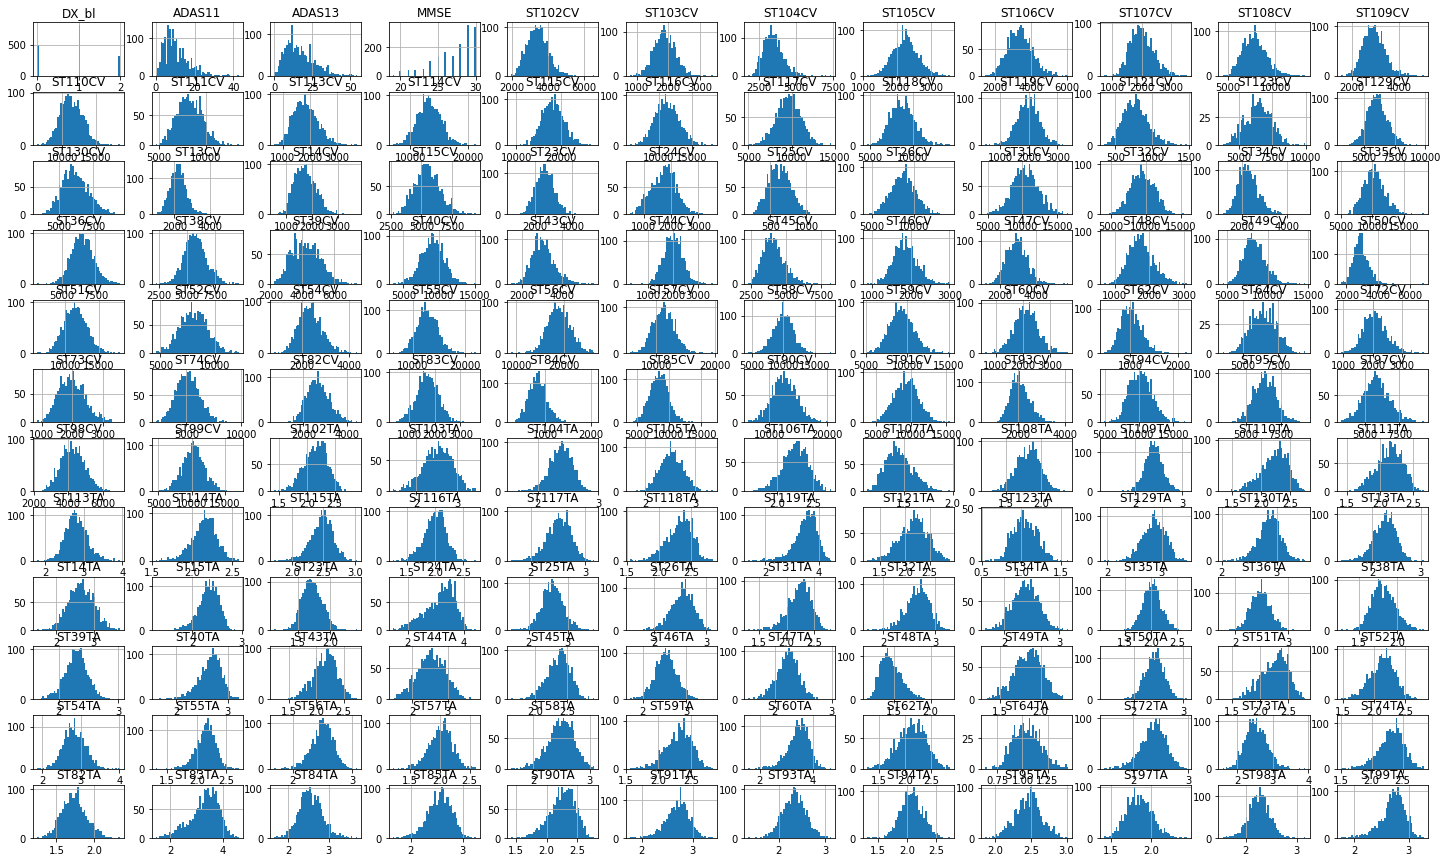

In [ ]:
alzheimers_data.hist(bins=50, figsize=(25,15))
plt.show()

### **Normality Test**

In [ ]:
alzheimers_data_columns = alzheimers_data.columns.tolist()

for i in alzheimers_data_columns:
  print('\n Column:', i, ', ', 'Length: ', alzheimers_data[i].notnull().sum(), '\n')
  print(normality_test(alzheimers_data[i]))


 Column: DX_bl ,  Length:  1607 

Using Shapiro-Wilky Test, the p-value is 0.0. Therefore, the data MAY NOT be drawn from a normal distribution
----------------------------------------------------------------------------------------------------------------------------------
Testing for lognormality . . .
Using Shapiro-Wilky Test, the p-value is 1.0. Therefore, the log(data) was drawn from a normal distribution.
None

 Column: ADAS11 ,  Length:  1607 

Using Shapiro-Wilky Test, the p-value is 0.0. Therefore, the data MAY NOT be drawn from a normal distribution
----------------------------------------------------------------------------------------------------------------------------------
Testing for lognormality . . .
Using Shapiro-Wilky Test, the p-value is 1.0. Therefore, the log(data) was drawn from a normal distribution.
None

 Column: ADAS13 ,  Length:  1607 

Using Shapiro-Wilky Test, the p-value is 0.0. Therefore, the data MAY NOT be drawn from a normal distribution
-----------

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Length:  1607 

Using Shapiro-Wilky Test, the p-value is 0.16249. Therefore, the data was drawn from a normal distribution.
None

 Column: ST32CV ,  Length:  1607 

Using Shapiro-Wilky Test, the p-value is 0.35071. Therefore, the data was drawn from a normal distribution.
None

 Column: ST34CV ,  Length:  1607 

Using Shapiro-Wilky Test, the p-value is 0.0. Therefore, the data MAY NOT be drawn from a normal distribution
----------------------------------------------------------------------------------------------------------------------------------
Testing for lognormality . . .
Using Shapiro-Wilky Test, the p-value is 0.52579. Therefore, the log(data) was drawn from a normal distribution.
None

 Column: ST35CV ,  Length:  1607 

Using Shapiro-Wilky Test, the p-value is 0.0. Therefore, the data MAY NOT be drawn from a normal distribution
----------------------------------------------------------------------------------------------------------------------------------
Testing for lognorm

* Using the Shapiro-Wilkey test, majority of the attributes MAY NOT be drawn from a normal distribution. 

* I still don't know how to handle this, so I will just disregard this information in the meantime.

---

### **Creating a test set**

#### **Random Sampling**

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(alzheimers_data, test_size=0.2, random_state=42)

#### **Stratified Sampling**

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(alzheimers_data, alzheimers_data["DX_bl"]):
  strat_train_set = alzheimers_data.loc[train_index]
  strat_test_set = alzheimers_data.loc[test_index]

#### **Sampling Bias**

In [ ]:
sampling_bias = pd.DataFrame({
    'Overall': [i for i in alzheimers_data["DX_bl"].value_counts()/len(alzheimers_data)],
    'Stratified': [i for i in strat_test_set["DX_bl"].value_counts()/len(strat_test_set)],
    'Random': [i for i in test_set["DX_bl"].value_counts()/len(test_set)],
    'Strat % Error': [i for i in (alzheimers_data["DX_bl"].value_counts()/len(alzheimers_data) - strat_test_set["DX_bl"].value_counts()/len(strat_test_set))*100],
    'Random % Error': [i for i in (alzheimers_data["DX_bl"].value_counts()/len(alzheimers_data) - test_set["DX_bl"].value_counts()/len(test_set))*100]

})

print('\n --Sampling Bias-- \n')
sampling_bias


 --Sampling Bias-- 



,Overall,Stratified,Random,Strat % Error,Random % Error
0,0.506534,0.506211,0.500000,0.032273,0.653391
1,0.301805,0.301242,0.285714,0.056237,1.609032
2,0.191661,0.192547,0.214286,-0.088510,-2.262423


* In the overall training dataset;
  1. **~50.7%** of the subjects are classified as **cognitively normal (Class = 0)**,
  2. **~30.2%** of the subjects are classified as having a **mild cognitive impairment (Class = 1)**,
  3. **~19.2%** of the subjects are classified as having **Alzheimer's disease (Class = 2)**.

* To mimic this distribution in the test set, **it is more reasonable to use the `strat_train_set` and `strat_test_set`.**

---

## **(02) Gaining insights from the data**

* First, I want to see how the other attributes are correlated with **ADAS13, ADAD11, and MMSE** attributes.

In [ ]:
corr_matrix = alzheimers_data.corr()

pd.set_option("display.max_rows", None, "display.max_columns", None)
corr_matrix_ADAS11_df = pd.DataFrame({
    'Pearson Correlation Coefficient (ADAS11)': corr_matrix["ADAS11"].sort_values(ascending=False),
})
corr_matrix_ADAS13_df = pd.DataFrame({
    'Pearson Correlation Coefficient (ADAS13)': corr_matrix["ADAS13"].sort_values(ascending=False),
})
corr_matrix_MMSE_df = pd.DataFrame({
    'Pearson Correlation Coefficient (MMSE)': corr_matrix["MMSE"].sort_values(ascending=False),
})

In [ ]:
corr_matrix_ADAS11_df

,Pearson Correlation Coefficient (ADAS11)
ADAS11,1.000000
ADAS13,0.975137
DX_bl,0.682012
ST14TA,-0.026242
ST73CV,-0.041753
ST14CV,-0.049176
ST73TA,-0.062458
ST23CV,-0.068610
ST43CV,-0.083984
ST102CV,-0.091098


* The most significant observation that we can get from this correlation matrix is that **the cortical volumes and average thicknesses of the 70 brain regions and MMSE have negative linear correlations with ADAS11 attribute**

  * This means that smaller values of the cortical volumes and average thicknesses of the 70 brain regions as well as low MMSE scores correspond to higher ADAS11 scores. 

In [ ]:
corr_matrix_ADAS13_df

,Pearson Correlation Coefficient (ADAS13)
ADAS13,1.000000
ADAS11,0.975137
DX_bl,0.722164
ST14TA,-0.025445
ST73CV,-0.043014
ST14CV,-0.051476
ST73TA,-0.057639
ST23CV,-0.075966
ST113TA,-0.085292
ST43CV,-0.090300


* Since ADAS13 have a positive correlation with ADAS11, we should expect that its correlation with the cortical volumes and average thicknesses of 70 brain regions and MMSE should behave in the same manner as the correlation of ADAS11 with these attributes.

* As can be seen from the table, the **ADAS13** attribute also has negative correlations with the cortical volumes and average thicknesses of the 70 brain regions and MMSE.

In [ ]:
corr_matrix_MMSE_df

,Pearson Correlation Coefficient (MMSE)
MMSE,1.000000
ST24TA,0.488183
ST40TA,0.464506
ST83TA,0.463840
ST26TA,0.445664
ST99TA,0.437439
ST85TA,0.431839
ST32TA,0.431070
ST91TA,0.421658
ST58TA,0.420759


* The **MMSE** attribute, on the other hand, has positive correlations with the cortical volumes and average thicknesses of the 70 brains regions, but it has negative correlations with the **ADAS11**, **ADAS13**, **DX_bl(diagnosis)** attributes.
  * Low MMSE scores correspond to small cortical volumes and small average thicknesses of 70 brain regions. **This also suggest that patients with low MMSE score have a higher probability of being diagnosed with Alzheimer's disease.** But the question now is how low?

### **Significant insights and questions**

* These are the significant inferences that we can take from these information:
  1. Subjects with high ADAS11 and ADAS13 scores, but low MMSE scores may be classified as having Alzheimer's disease,
  2. Subjects with small (or should I say reduced) cortical volumes and average thicknesses in their 70 brain regions may be classified as having Alzheimer's disease.

* **Although beyond the scope of this project, yet these are the interesting points which can be learned from this dataset**:
  1. How high should the ADAS11 and ADAS13 scores be for a patient to be classified as having Alzheimer's disease?
  2. How low should the MMSE score be for a patient to classified as having Alzheimer's disease?
  3. If there are shrinkages in specific regions of the brain, what are these regions that we should be looking at for a patient to be classified as having Alzheimer's disease?
  4. Much harder Question:
    * What is the percentage of shrinkage in that specific region should be for a patient to be classified as having Alzheimer's disease? This is difficult becauase this requires a long-term observation. The patients should be observed when they are still cognitively normal.
    * What leads to the shrinkage in these regions?

## **(03) Preparing the data for ML algorithms**

#### **Separating features and labels**

In [ ]:
# Features
alzheimers_data = strat_train_set.drop(["DX_bl", "ADAS11", "ADAS13", "MMSE"], axis=1)
print('\n --Shape of the feature matrix-- \n')
print(alzheimers_data.shape)

# Label for the classification task
alzheimers_data_classification_labels = strat_train_set["DX_bl"].copy()
print('\n --Shape of the classification label-- \n')
print(alzheimers_data_classification_labels.shape)

# Labels for the regression task
alzheimers_data_regression_labels = strat_train_set[["ADAS11", "ADAS13", "MMSE"]].copy()
print('\n --Shape of the regression labels-- \n')
print(alzheimers_data_regression_labels.shape)


 --Shape of the feature matrix-- 

(1285, 140)

 --Shape of the classification label-- 

(1285,)

 --Shape of the regression labels-- 

(1285, 3)


#### **Transformation Pipeline**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
                         ('imputer', IterativeImputer(max_iter=1024, random_state=42)),
                         ('power_transformer', PowerTransformer(method='box-cox')),
                         #('scaler', StandardScaler())
])

In [ ]:
from sklearn.compose import ColumnTransformer

import pandas as pd
num_attribs = list(alzheimers_data)

full_pipeline = ColumnTransformer([
                                   ('num', num_pipeline, num_attribs),
                                   
])

alzheimers_data_prepared = full_pipeline.fit_transform(alzheimers_data)
alzheimers_data_prepared_df = pd.DataFrame(alzheimers_data_prepared, columns=alzheimers_data.columns, index=alzheimers_data.index)

In [ ]:
alzheimers_data_prepared_df.describe()

,ST102CV,ST103CV,ST104CV,ST105CV,ST106CV,ST107CV,ST108CV,ST109CV,ST110CV,ST111CV,ST113CV,ST114CV,ST115CV,ST116CV,ST117CV,ST118CV,ST119CV,ST121CV,ST123CV,ST129CV,ST130CV,ST13CV,ST14CV,ST15CV,ST23CV,ST24CV,ST25CV,ST26CV,ST31CV,ST32CV,ST34CV,ST35CV,ST36CV,ST38CV,ST39CV,ST40CV,ST43CV,ST44CV,ST45CV,ST46CV,ST47CV,ST48CV,ST49CV,ST50CV,ST51CV,ST52CV,ST54CV,ST55CV,ST56CV,ST57CV,ST58CV,ST59CV,ST60CV,ST62CV,ST64CV,ST72CV,ST73CV,ST74CV,ST82CV,ST83CV,ST84CV,ST85CV,ST90CV,ST91CV,ST93CV,ST94CV,ST95CV,ST97CV,ST98CV,ST99CV,ST102TA,ST103TA,ST104TA,ST105TA,ST106TA,ST107TA,ST108TA,ST109TA,ST110TA,ST111TA,ST113TA,ST114TA,ST115TA,ST116TA,ST117TA,ST118TA,ST119TA,ST121TA,ST123TA,ST129TA,ST130TA,ST13TA,ST14TA,ST15TA,ST23TA,ST24TA,ST25TA,ST26TA,ST31TA,ST32TA,ST34TA,ST35TA,ST36TA,ST38TA,ST39TA,ST40TA,ST43TA,ST44TA,ST45TA,ST46TA,ST47TA,ST48TA,ST49TA,ST50TA,ST51TA,ST52TA,ST54TA,ST55TA,ST56TA,ST57TA,ST58TA,ST59TA,ST60TA,ST62TA,ST64TA,ST72TA,ST73TA,ST74TA,ST82TA,ST83TA,ST84TA,ST85TA,ST90TA,ST91TA,ST93TA,ST94TA,ST95TA,ST97TA,ST98TA,ST99TA
count,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03
mean,-2.703587e-15,-2.642072e-16,1.743171e-14,-1.851524e-16,1.804523e-15,4.849558e-16,-6.977557e-15,-5.278268e-15,4.001123e-16,-1.180508e-15,2.882346e-15,-1.758991e-15,-4.552778e-16,-6.733049e-16,1.310182e-16,1.698900e-15,-4.687992e-16,-3.023954e-18,-7.551245e-17,2.023025e-15,1.677776e-15,-1.101238e-15,2.394107e-16,1.303756e-15,-4.568762e-16,-8.268138e-16,2.998034e-16,-6.437782e-16,-4.334622e-16,-7.556428e-16,-2.324708e-15,6.137681e-16,4.674601e-16,1.295937e-15,-4.995572e-16,-2.732358e-16,4.178607e-15,-1.289068e-16,3.302849e-15,9.253299e-17,3.010130e-16,5.768408e-16,-4.603894e-15,1.042625e-14,-2.108128e-16,-6.511004e-16,-5.758472e-16,5.394734e-16,1.000756e-15,4.271551e-16,9.691340e-16,8.714171e-16,1.459490e-16,-1.387217e-15,4.043458e-17,-1.409940e-15,-8.127956e-16,-5.434477e-16,-7.938311e-16,1.572456e-17,-7.275201e-16,1.114910e-15,2.643800e-16,6.701082e-16,1.875197e-15,-2.848564e-16,-2.596766e-16,5.770568e-16,3.085297e-16,1.741149e-16,3.093073e-17,1.000497e-16,-3.404108e-16,-1.036784e-17,3.085297e-16,2.181135e-16,-3.163920e-16,-1.324146e-15,2.298205e-17,-7.214722e-16,-2.463432e-15,2.493466e-16,-2.172063e-16,-7.749962e-17,3.002354e-16

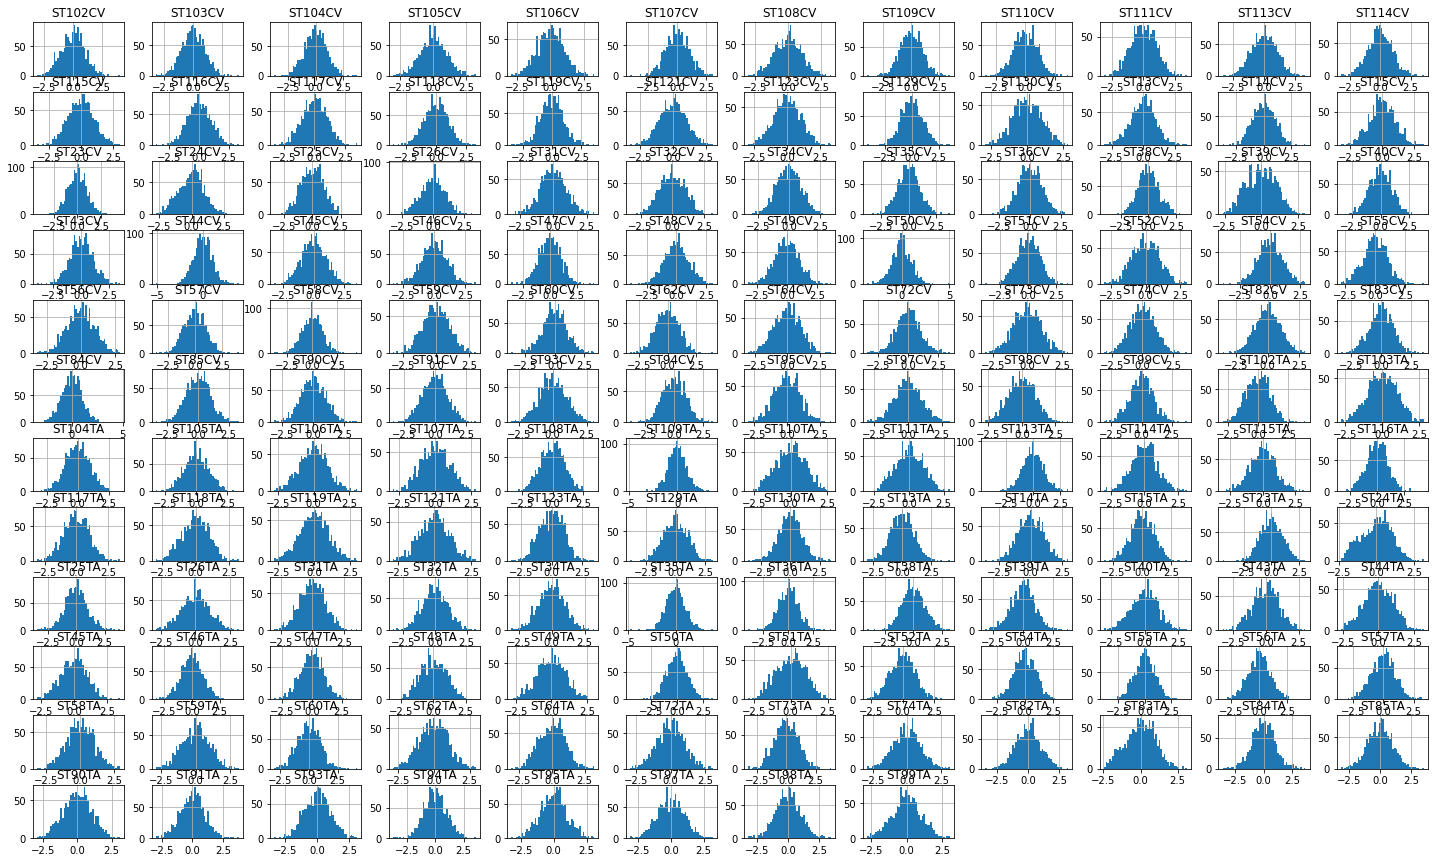

In [ ]:
alzheimers_data_prepared_df.hist(bins=50, figsize=(25,15))
plt.show()

In [ ]:
for i in alzheimers_data_columns[4:]:
  print('\n --{}-- \n'.format(i))
  print(normality_test(alzheimers_data_prepared_df[i]))


 --ST102CV-- 

Using Shapiro-Wilky Test, the p-value is 0.20032. Therefore, the data was drawn from a normal distribution.
None

 --ST103CV-- 

Using Shapiro-Wilky Test, the p-value is 0.76218. Therefore, the data was drawn from a normal distribution.
None

 --ST104CV-- 

Using Shapiro-Wilky Test, the p-value is 0.15124. Therefore, the data was drawn from a normal distribution.
None

 --ST105CV-- 

Using Shapiro-Wilky Test, the p-value is 0.79524. Therefore, the data was drawn from a normal distribution.
None

 --ST106CV-- 

Using Shapiro-Wilky Test, the p-value is 0.93194. Therefore, the data was drawn from a normal distribution.
None

 --ST107CV-- 

Using Shapiro-Wilky Test, the p-value is 0.67698. Therefore, the data was drawn from a normal distribution.
None

 --ST108CV-- 

Using Shapiro-Wilky Test, the p-value is 0.39979. Therefore, the data was drawn from a normal distribution.
None

 --ST109CV-- 

Using Shapiro-Wilky Test, the p-value is 0.43272. Therefore, the data was drawn f

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


None

 --ST43TA-- 

Using Shapiro-Wilky Test, the p-value is 0.66523. Therefore, the data was drawn from a normal distribution.
None

 --ST44TA-- 

Using Shapiro-Wilky Test, the p-value is 0.01564. Therefore, the data MAY NOT be drawn from a normal distribution
----------------------------------------------------------------------------------------------------------------------------------
Testing for lognormality . . .
Using Shapiro-Wilky Test, the p-value is 1.0. Therefore, the log(data) was drawn from a normal distribution.
None

 --ST45TA-- 

Using Shapiro-Wilky Test, the p-value is 0.17037. Therefore, the data was drawn from a normal distribution.
None

 --ST46TA-- 

Using Shapiro-Wilky Test, the p-value is 0.4361. Therefore, the data was drawn from a normal distribution.
None

 --ST47TA-- 

Using Shapiro-Wilky Test, the p-value is 0.49502. Therefore, the data was drawn from a normal distribution.
None

 --ST48TA-- 

Using Shapiro-Wilky Test, the p-value is 0.03701. Therefore, the

* Fair enough, majority of the features now have normal-like distributions. 
  *  Now, I just hope that this will give a good MAE scores on different classification models.

## **(04) Training different regression models**

#### **(00) Preliminary Evaluation of ML Regression Models**

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoLars
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor


models = []
models.append(('Dummy', DummyRegressor()))
models.append(('lin_reg', LinearRegression()))
models.append(('SGDRegressor (multioutput)', MultiOutputRegressor(SGDRegressor(alpha=0.1, loss='epsilon_insensitive', epsilon=0, max_iter=1000, learning_rate='adaptive', penalty='elasticnet'))))
models.append(('SGDRegressor (regressorchain)', RegressorChain(SGDRegressor(alpha=0.1, loss='epsilon_insensitive', epsilon=0, max_iter=1000, learning_rate='adaptive', penalty='elasticnet'))))
models.append(('Elastic Net', ElasticNet(alpha=0.001, l1_ratio=0.5)))
models.append(('LARS Lasso', LassoLars(alpha=0.001)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('Decision Tree', DecisionTreeRegressor()))
models.append(('SVM (multioutput)', MultiOutputRegressor(LinearSVR())))
models.append(('SVM (regression chain)', RegressorChain(LinearSVR())))
models.append(('PLSRegression', PLSRegression()))
models.append(('GradientBoostingRegressor (multioutput)', MultiOutputRegressor(GradientBoostingRegressor(random_state=42))))
models.append(('GradientBoostingRegressor (regressor chain)', RegressorChain(GradientBoostingRegressor(random_state=42))))

names = []
scores = []

for name, model in models:
  kfold = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)
  cv_scores = cross_val_score(model, alzheimers_data_prepared, alzheimers_data_regression_labels, cv=kfold, scoring="neg_mean_absolute_error", n_jobs=-1, error_score='raise')
  scores.append(np.absolute(cv_scores))
  names.append(name)
  print('%s (MAE): %f (%f)' % (name, np.absolute(cv_scores).mean(), np.absolute(cv_scores).std()))

Dummy (MAE): 4.931294 (0.307889)
lin_reg (MAE): 3.856445 (0.227885)
SGDRegressor (multioutput) (MAE): 3.737439 (0.244086)
SGDRegressor (regressorchain) (MAE): 3.758531 (0.249701)
Elastic Net (MAE): 3.852592 (0.228065)
LARS Lasso (MAE): 3.755945 (0.233007)
KNN (MAE): 4.069771 (0.263717)
Decision Tree (MAE): 5.109860 (0.343947)
SVM (multioutput) (MAE): 3.923493 (0.235195)
SVM (regression chain) (MAE): 3.944201 (0.244411)
PLSRegression (MAE): 3.857039 (0.249639)
GradientBoostingRegressor (multioutput) (MAE): 3.640095 (0.217009)
GradientBoostingRegressor (regressor chain) (MAE): 3.627659 (0.220124)


* Using a repeated 10-fold cross validation with 5 repeats, **a dummy classifier has achieved a mean absolute error (MAE) of about 4.93**. This will be the basis for the selection of several promising regression models.

* From this preliminary evaluation, the promising regression models are:
  1. GradientBoostingRegressor (regressor chain)
  2. SGDRegressor [I have opted to exclude this in my model comparison]
  3. LARS Lasso
  4. Elastic Net
  5. PLSRegresssion

### **(01) `GradientBoostingRegressor (regressor chain)`**

In [ ]:
grad_boost_reg = RegressorChain(GradientBoostingRegressor(random_state=42))
grad_boost_reg.fit(alzheimers_data_prepared, alzheimers_data_regression_labels)

RegressorChain(base_estimator=GradientBoostingRegressor(alpha=0.9,
                                                        ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='ls', max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
   

In [ ]:
#cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)
grad_boost_reg_cv_scores = cross_val_score(grad_boost_reg, alzheimers_data_prepared, alzheimers_data_regression_labels, cv=10, scoring="neg_mean_absolute_error", n_jobs=-1)
print('\n --Ten-fold cross-validation MAE scores for GradientBoostingRegressor-- \n')
print(np.absolute(grad_boost_reg_cv_scores))
print('\n --Average of the Ten-fold cross-validation MAE scores for GradientBoostingRegressor-- \n')
print(np.absolute(grad_boost_reg_cv_scores).mean())


 --Ten-fold cross-validation MAE scores for GradientBoostingRegressor-- 

[3.79744597 3.49250197 3.27075696 3.98855622 3.61918393 3.6710899
 3.36076673 3.57006198 3.57368131 3.67009437]

 --Average of the Ten-fold cross-validation MAE scores for GradientBoostingRegressor-- 

3.601413933273612


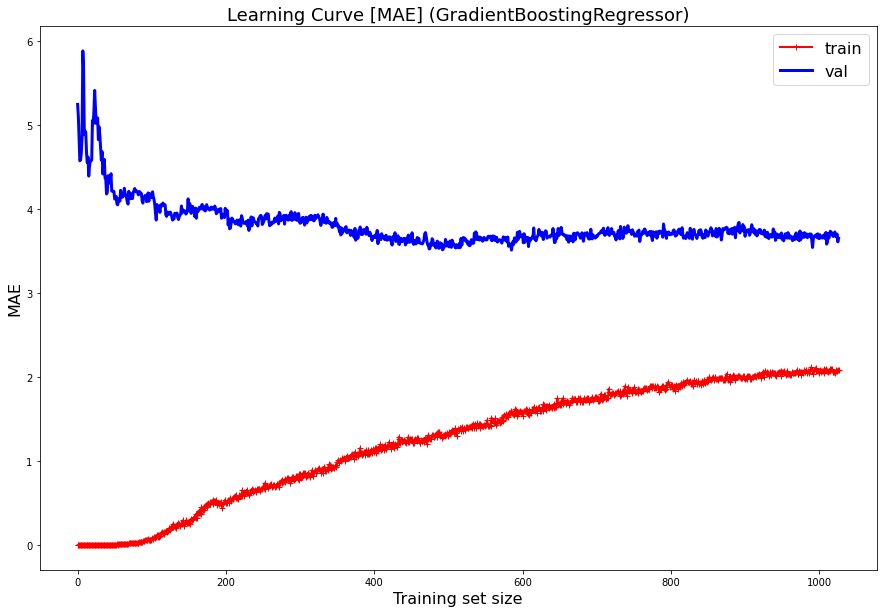

In [ ]:
plot_learning_curves_MAE(grad_boost_reg, alzheimers_data_prepared, alzheimers_data_regression_labels, (15,10), 'GradientBoostingRegressor')

### **(02) Least-angle Regression (LARS) Lasso**

In [ ]:
lars_lasso_reg = LassoLars(alpha=0.001)
lars_lasso_reg.fit(alzheimers_data_prepared, alzheimers_data_regression_labels)

LassoLars(alpha=0.001, copy_X=True, eps=2.220446049250313e-16,
          fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
          positive=False, precompute='auto', verbose=False)

In [ ]:
lars_lasso_reg_cv_scores = cross_val_score(lars_lasso_reg, alzheimers_data_prepared, alzheimers_data_regression_labels, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)
print('\n --Ten-fold cross-validation MAE scores for LASSO LARS-- \n')
print(np.absolute(lars_lasso_reg_cv_scores))
print('\n --Average of the Ten-fold cross-validation MAE scores for LASSO LARS-- \n')
print(np.absolute(lars_lasso_reg_cv_scores).mean())


 --Ten-fold cross-validation MAE scores for LASSO LARS-- 

[3.92939694 3.51951915 3.33116352 4.29813615 3.87266991 3.94722073
 3.34320848 3.85799985 3.59464827 3.69745437]

 --Average of the Ten-fold cross-validation MAE scores for LASSO LARS-- 

3.7391417376872638


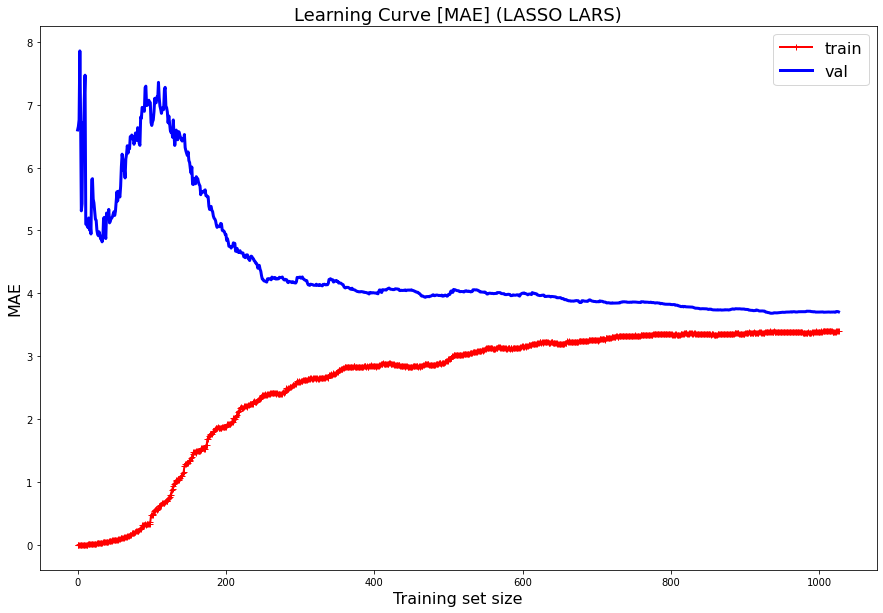

In [ ]:
plot_learning_curves_MAE(lars_lasso_reg, alzheimers_data_prepared, alzheimers_data_regression_labels, (15,10), 'LASSO LARS')

### **(03) Elastic Net**

In [ ]:
elastic_net_reg = ElasticNet(alpha=0.001, l1_ratio=0.5)
elastic_net_reg.fit(alzheimers_data_prepared, alzheimers_data_regression_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1185.793598266191, tolerance: 5.36244128988327
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2107.1569033581545, tolerance: 11.39516851167315
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115.94660607684636, tolerance: 0.9012899610894938
  positive)


ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
elastic_net_reg_cv_scores = cross_val_score(elastic_net_reg, alzheimers_data_prepared, alzheimers_data_regression_labels, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)
print('\n --Ten-fold cross-validation MAE scores for Elastic Net-- \n')
print(np.absolute(elastic_net_reg_cv_scores))
print('\n --Average of the Ten-fold cross-validation MAE scores for Elastic Net-- \n')
print(np.absolute(elastic_net_reg_cv_scores).mean())


 --Ten-fold cross-validation MAE scores for Elastic Net-- 

[3.98660865 3.59646298 3.53401676 4.36421396 3.9222053  3.99405483
 3.43459213 4.03735466 3.72785212 3.7589953 ]

 --Average of the Ten-fold cross-validation MAE scores for Elastic Net-- 

3.835635670581727


### **(04) PLS Regression**

In [ ]:
pls_reg = PLSRegression()
pls_reg.fit(alzheimers_data_prepared, alzheimers_data_regression_labels)

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

In [ ]:
pls_reg_cv_scores = cross_val_score(pls_reg, alzheimers_data_prepared, alzheimers_data_regression_labels, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)
print('\n --Ten-fold cross-validation MAE scores for PLSRegression-- \n')
print(np.absolute(pls_reg_cv_scores))
print('\n --Average of the Ten-fold cross-validation MAE scores for PLSRegression-- \n')
print(np.absolute(elastic_net_reg_cv_scores).mean())


 --Ten-fold cross-validation MAE scores for PLSRegression-- 

[4.0907138  3.73597266 3.37280763 4.33176512 4.07605548 4.02295191
 3.5437313  3.98600725 3.51109188 3.8904212 ]

 --Average of the Ten-fold cross-validation MAE scores for PLSRegression-- 

3.835635670581727


* Basing on the average MAE scores, the best regression model is **`RegressorChain(GradientBoostingRegressor)`**

* The next step that I will do is fine-tuning the hyperparametes of this model.

## **(05) Fine-tuning the best model**

In [ ]:
grad_boost_reg.get_params()

{'base_estimator': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False),
 'base_estimator__alpha': 0.9,
 'base_estimator__ccp_alpha': 0.0,
 'base_estimator__criterion': 'friedman_mse',
 'base_estimator__init': None,
 'base_estimator__learning_rate': 0.1,
 'base_estimator__loss': 'ls',
 'base_estimator__max_depth': 3,
 'base_estimator__max_features': None,
 'base_estimator__max_l

In [ ]:
loss = ['ls', 'lad', 'huber', 'quantile']
learning_rate = [1e-3, 1e-2, 0.1]
#n_estimators = [100, 300, 600, 900, 1200, 1500]
criterion = ['friedman_mse', 'mse', 'mae']
min_samples_plit = [2, 4, 8, 16, 32, 64]
max_depth = [2, 4, 8, 16, 32, 64]
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)


param_grid = {
    'base_estimator__loss': loss,
    'base_estimator__learning_rate': learning_rate,
    #'base_estimator__n_estimators': n_estimators,
    'base_estimator__criterion': criterion,
    'base_estimator__min_samples_split': min_samples_plit,
    'base_estimator__max_depth': max_depth
}


grad_boost_grid_search = GridSearchCV(grad_boost_reg, param_grid, scoring='neg_mean_absolute_error', cv=cv, verbose=4, n_jobs=-1)

In [ ]:
grad_boost_search_result = grad_boost_grid_search.fit(alzheimers_data_prepared, alzheimers_data_regression_labels)

Fitting 50 folds for each of 1296 candidates, totalling 64800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed: 54.2min
[Parallel(n_jobs=-1)]: Done 609 tasks      | elapsed: 104.6min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed: 207.7min
[Parallel(n_jobs=-1)]: Done 1197 tasks      | elapsed: 371.2min
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed: 578.4min


#### **Defininig my best regressor**

In [ ]:
myBest_regressor = grad_boost_search_result.best_estimator_
dump(myBest_regressor, 'myBest_regressor.pkl')

NameError: ignored

#### **Cross-validation score**


In [ ]:
cross_val_score(myBest_regressor, alzheimers_data_prepared, alzheimers_data_regression_labels, cv=10, scoring="neg_mean_absolute_error", n_jobs=-1)

In [ ]:
best_regressor_cv_scores = cross_val_score(myBest_regressor, alzheimers_data_prepared, alzheimers_data_regression_labels, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)
print('\n --Ten-fold cross-validation MAE scores for myBest_regressor-- \n')
print(np.absolute(best_regressor_cv_scores))
print('\n --Average of the Ten-fold cross-validation MAE scores for myBest_regressor-- \n')
print(np.absolute(best_regressor_cv_scores).mean())


 --Ten-fold cross-validation MAE scores for LASSO LARS-- 

[3.92939694 3.51951915 3.33116352 4.29813615 3.8726699  3.94722073
 3.34320848 3.85799984 3.59464827 3.69745437]

 --Average of the Ten-fold cross-validation MAE scores for LASSO LARS-- 

3.7391417357631958


## **(06) Full Pipeline with both preparation and regressor**

#### **Not yet fine-tuned model**

In [ ]:
full_pipeline_with_regressor = Pipeline([
                                         ("preparation", full_pipeline),
                                         #("regressor", myBest_regressor)
                                         ("regressor", grad_boost_reg)
])

### **Fine-tuned model**

In [ ]:
full_pipeline_with_fine_tuned_regressor = Pipeline([
                                         ("preparation", full_pipeline),
                                         ("regressor", myBest_regressor)
])

### **Model persistence using joblib**

#### **Not yet fine-tuned model**

In [ ]:
myBest_regressor_model = full_pipeline_with_regressor

dump(myBest_regressor_model, 'myBest_regressor_model.pkl')

['myBest_regressor_model.pkl']

#### **Fine-tuned model**

In [ ]:
myBest_regressor_fine_tuned_model = full_pipeline_with_fine_tuned_regressor

dump(myBest_regressor_fine_tuned_model, 'myBest_regressor_fine_tuned_model.pkl')

## **(07) Evaluating on the test set**

### **Separating features and labels**

In [ ]:
# Features
alzheimers_test_data = strat_test_set.drop(["DX_bl", "ADAS11", "ADAS13", "MMSE"], axis=1)
print('\n --Shape of the feature matrix-- \n')
print(alzheimers_test_data.shape)

# Label for the classification task
alzheimers_test_data_classification_labels = strat_test_set["DX_bl"].copy()
print('\n --Shape of the classification label-- \n')
print(alzheimers_test_data_classification_labels.shape)

# Labels for the regression task
alzheimers_test_data_regression_labels = strat_test_set[["ADAS11", "ADAS13", "MMSE"]].copy()
print('\n --Shape of the regression labels-- \n')
print(alzheimers_test_data_regression_labels.shape)


 --Shape of the feature matrix-- 

(322, 140)

 --Shape of the classification label-- 

(322,)

 --Shape of the regression labels-- 

(322, 3)


In [ ]:
alzheimers_test_data_regression_pred =  myBest_regressor_model.predict(alzheimers_test_data)
print(alzheimers_test_data_regression_pred)

[[16.03527731 25.93576024 24.49142529]
 [ 7.19484586 11.85253276 28.70302227]
 [13.41407944 22.21732103 25.96707171]
 [ 6.86702906 10.65750159 28.81838862]
 [ 7.09066145 11.36127441 28.64005632]
 [ 6.3713427  10.76383264 28.72212088]
 [ 7.35353833 11.60083879 28.67011778]
 [ 6.95171642 12.0821246  28.33920986]
 [11.11553719 16.75005019 27.44237693]
 [12.01586016 20.12596089 26.90176628]
 [ 7.61668226 13.32993327 28.56714344]
 [13.11536592 21.9283091  26.24513906]
 [ 7.21758273 11.44638934 28.83293769]
 [20.04787906 31.30389539 24.22157757]
 [ 8.02494232 12.66237426 28.48481138]
 [ 6.14758053  9.11746357 29.23674711]
 [11.18769449 19.54394474 27.38897661]
 [28.80833641 39.84230421 22.69252261]
 [11.59021723 19.04925656 26.65934079]
 [ 8.85553442 15.81105196 27.81174605]
 [ 7.09987412 11.68392329 28.63807402]
 [13.88806759 22.43361054 25.44905558]
 [ 6.72407293 10.36988936 28.6807785 ]
 [ 8.84694989 14.05238199 28.5077691 ]
 [ 8.03866974 12.07814948 28.83021306]
 [ 6.70068345 10.87955714

In [ ]:
print('MAE (not yet fine-tuned model): ', mean_absolute_error(alzheimers_test_data_regression_labels, alzheimers_test_data_regression_pred))

MAE (not yet fine-tuned model):  3.6171460425126085


In [ ]:
while True:pass